### Setup

Background packages

In [5]:
import mesa
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Creating Agents 

*Background*: Agents are the individual entities that act in the model. It is a good modeling practice to make certain each Agent can be uniquely identified.

*Model-specific information*: Agents are the individuals that exchange money, in this case the amount of money an individual agent has is represented as wealth. Additionally, agents each have a unique identifier.

*Code implementation*: This is done by creating a new class (or object) that extends mesa.Agent creating a subclass of the Agent class from mesa. The new class is named *MoneyAgent*. The technical details about the agent object can be found in the mesa repo.
The MoneyAgent class is created with the following code:

In [17]:
class PlayerAgent(mesa.Agent):
    """A player with fixed initial type and skill."""

    def __init__(self, unique_id, model, skill, agent_type):
        # Pass the parameters to the parent class.
        super().__init__(unique_id, model)

        # Create the agent's variable and set the initial values.
        self.skill = skill
        self.agent_type = agent_type

### Creating the Model

##### Background
Model can be visualized as a grid containing all agents. Creating, holding, and managing all agents on the grid. It evolves in discrete time stress. 

##### Model-specific Information 
When a model is created the number of agents within the model is specified. The model then creates the agents and places them on the grid. The model also contains a scheduler which controls the order in which agents are activated. The scheduler is also responsible for advancing the model by one step. The model also contains a data collector which collects data from the model. These topics will be covered in more detail later in the tutorial.

##### Code Implementation 
This is done by creating a new class (or object) that extends mesa.Model creating a subclass of the Model class from mesa. The new class is named MoneyModel. The technical details about the agent object can be found in the mesa repo. The MoneyModel class is created with the following code:



In [14]:
class RugbyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, N):
        self.num_agents = N
        # Create agents
        for i in range(self.num_agents):
            a = PlayerAgent(i, self, agent_type, skill)

### Building out the Scheduler

__Background__: Order of agent activation and advancing the model. A step is the smallest unit. 
__Model-Specific Information__: A class called `RandomActivationByAgent` is created. This extends `mesa.time.RandomActivation` creating a subclass of `RandomActivation` class from Mesa. This class activates all agents __once per step__. 
__Code Implementation__: Technical details about timer object can be found in the mesa repo. The `MoneyAgent` code is modified to show when a new agent is created. 



In [50]:
### THIS CODE WORKS!

class PlayerAgent(mesa.Agent):
    """A player with fixed initial type and skill."""

    def __init__(self, unique_id, model, agent_type, skill, group):
        # Pass the parameters to the parent class.
        super().__init__(unique_id, model)

        # Create the agent's attribute and set the initial values.
        self.skill = skill
        self.agent_type = agent_type
        self.group = group

    def step(self):
        # The agent's step will go here.
        # For demonstration purposes we will print the agent's unique_id
        print(f"I am player {str(self.unique_id)}. My type is {self.agent_type}, my skill is {self.skill}, and my group is {self.group}.")


class RugbyModel(mesa.Model):
    """A model with some number of players."""

    def __init__(self, N):
        self.num_agents = N
        # Create scheduler and assign it to the model
        self.schedule = mesa.time.RandomActivation(self)

        mu_type, sigma_type = 0.5, 0.15  # mean and standard deviation for type
        mu_skill, sigma_skill = 2.5, 1.0  # mean and standard deviation for skill


        # Create agents
        for i in range(self.num_agents):
            group = '1' if i % 2 == 0 else '2'
            
            agent_type = np.clip(np.random.normal(mu_type, sigma_type), 0, 1)
            skill = np.clip(np.random.normal(mu_skill, sigma_skill), 0, 5)

            a = PlayerAgent(i, self, agent_type, skill, group)
            # Add the agent to the scheduler
            self.schedule.add(a)

    def step(self):
        """Advance the model by one step."""

        # The model's step will go here for now this will call the step method of each agent and print the agent's unique_id
        self.schedule.step()

### Running the Model 
This has created a basic model. You can run it by _creating a model object and calling the step method_. It will run for one step and print the unique_id of each agent. 

Running the model for multiple steps is done by _calling the step method multiple times_.

You then need to __create the model object__ and run it for one step.

In [51]:
starter_model = RugbyModel(10)
starter_model.step()

I am player 4. My type is 0.36508726469020025, my skill is 2.755879494965034, and my group is 1.
I am player 2. My type is 0.5821847256103938, my skill is 2.410529752256958, and my group is 1.
I am player 0. My type is 0.4082978684514143, my skill is 2.0337693201080347, and my group is 1.
I am player 1. My type is 0.5197078087920851, my skill is 2.7609978358755924, and my group is 2.
I am player 9. My type is 0.5269077888148324, my skill is 1.9874681982223388, and my group is 2.
I am player 6. My type is 0.4898922867874547, my skill is 3.239580339891392, and my group is 1.
I am player 8. My type is 0.4875581845335208, my skill is 2.4525823404320706, and my group is 1.
I am player 7. My type is 0.5225545030216819, my skill is 2.450189875410326, and my group is 2.
I am player 5. My type is 0.16892560860134825, my skill is 1.664862021179679, and my group is 2.
I am player 3. My type is 0.516362023556404, my skill is 3.0951043024419613, and my group is 2.


### Agent Step – Development of Actions. More Complicated

Return to the MoneyAgent, the actual step process will now be created. 

__Background__: This is where the agent's behavior as it relates to each step is defined.

__Model-specific info__: In this case, the agent will check its wealth, and if it has money, give another unit away to another random agent.

__Code Implementation__: The agent's step method is called by the scheduler during __each step__ of the model. To allow the agent tochoose another agent at random, we use the `model.random` random-number generator. This works just like Python's `random` module, but with a fixed seed set at instantiation to allow replication.

In [56]:
### Working CODE!! 

import copy
import random
import numpy as np
import mesa

class PlayerAgent(mesa.Agent):
    """A player with fixed initial type and skill."""

    def __init__(self, unique_id, model, agent_type, skill, group):
        super().__init__(unique_id, model)
        self.skill = skill
        self.agent_type = agent_type
        self.group = group

    def fight(self):
        self_combined_score = self.skill * self.agent_type  # Calculate the agent's combined score
        group_ranked = self.model.group_ranked[self.group]  # Get the ranked list from the model

        # Select eligible opponents within the combined score range
        competition = [agent for agent in group_ranked if abs((agent.skill * agent.agent_type) - self_combined_score) <= 0.1]
        if not competition or len(competition) == 1:  # If no or only one agent in competition, no fight occurs
            return

        index = group_ranked.index(self)  # Find self in the ranked list
        adjacent = [agent for i, agent in enumerate(group_ranked) if abs(i - index) == 1 and agent in competition]

        if not adjacent:  # If no adjacent agents in competition, no fight occurs
            return

        opponent = random.choice(adjacent)  # Randomly choose an adjacent agent in competition

        # Randomly decide the outcome of the fight
        winner, loser = (self, opponent) if random.random() < 0.5 else (opponent, self)

        # Winner increases type score by 0.05, capped at 1
        winner.agent_type = min(winner.agent_type + 0.05, 1)

        # Loser decreases type score by 0.08, not falling below 0
        loser.agent_type = max(loser.agent_type - 0.08, 0)

        # For demonstration purposes, print the outcome
        print(f"Player {winner.unique_id} won the fight against player {loser.unique_id}.")
    
    def develop(self):
        # Increase the skill score by 0.05, ensure it does not exceed 5
        self.skill = min(self.skill + 0.05, 5)
    
    def step(self):
        # Randomly choose to fight or develop
        action = random.choice(['F', 'D'])
        if action == 'F':
            self.fight()
        else:
            self.develop()
        
        # Print the agent's action for demonstration purposes
        print(f"I am player {self.unique_id}. I chose to {'fight' if action == 'F' else 'develop'}. My type is {self.agent_type}, and my skill is {self.skill}.")

    def self_combined_score(self):
        return self.skill * self.agent_type



class RugbyModel(mesa.Model):
    """A model with some number of players."""

    def __init__(self, N):
        self.num_agents = N
        # Create scheduler and assign it to the model
        self.schedule = mesa.time.RandomActivation(self)

        mu_type, sigma_type = 0.5, 0.15  # mean and standard deviation for type
        mu_skill, sigma_skill = 2.5, 1.0  # mean and standard deviation for skill


        # Create agents
        for i in range(self.num_agents):
            group = '1' if i % 2 == 0 else '2'
            
            agent_type = np.clip(np.random.normal(mu_type, sigma_type), 0, 1)
            skill = np.clip(np.random.normal(mu_skill, sigma_skill), 0, 5)

            a = PlayerAgent(i, self, agent_type, skill, group)
            # Add the agent to the scheduler
            self.schedule.add(a)

    def rank_agents(self):
        # This function will be called to rank agents before they take their steps.
        self.group_ranked = {}
        for group_id in set(agent.group for agent in self.schedule.agents):
            # Create a ranked list for each group
            self.group_ranked[group_id] = sorted(
                [agent for agent in self.schedule.agents if agent.group == group_id],
                key=lambda x: x.skill * x.agent_type
            )

    def step(self):
        """Advance the model by one step."""
        # Rank agents at the start of each step
        self.rank_agents()
        
        # The model's step will go here for now this will call the step method of each agent and print the agent's unique_id
        self.schedule.step()





In [358]:
starter_model = RugbyModel(10)
starter_model.step()

### Basic Visualizations 

Just trying to build the above (working) code towards something that looks like an analysis. Step by step! 

In [360]:
### New test code on building visualizations

import copy
import random
import numpy as np
import mesa

class PlayerAgent(mesa.Agent):
    """A player with fixed initial type and skill."""

    def __init__(self, unique_id, model, agent_type, skill, group):
        super().__init__(unique_id, model)
        self.skill = skill
        self.agent_type = agent_type
        self.group = group

    def fight(self):
        self_combined_score = self.skill * self.agent_type  # Calculate the agent's combined score
        group_ranked = self.model.group_ranked[self.group]  # Get the ranked list from the model

        # Select eligible opponents within the combined score range
        competition = [agent for agent in group_ranked if abs((agent.skill * agent.agent_type) - self_combined_score) <= 0.1]
        if not competition or len(competition) == 1:  # If no or only one agent in competition, no fight occurs
            return

        index = group_ranked.index(self)  # Find self in the ranked list
        adjacent = [agent for i, agent in enumerate(group_ranked) if abs(i - index) == 1 and agent in competition]

        if not adjacent:  # If no adjacent agents in competition, no fight occurs
            return

        opponent = random.choice(adjacent)  # Randomly choose an adjacent agent in competition

        # Randomly decide the outcome of the fight
        winner, loser = (self, opponent) if random.random() < 0.5 else (opponent, self)

        # Winner increases type score by 0.05, capped at 1
        winner.agent_type = min(winner.agent_type + 0.05, 1)

        # Loser decreases type score by 0.08, not falling below 0
        loser.agent_type = max(loser.agent_type - 0.08, 0)

        # For demonstration purposes, print the outcome
        #print(f"Player {winner.unique_id} won the fight against player {loser.unique_id}.")
    
    def develop(self):
        # Increase the skill score by 0.05, ensure it does not exceed 5
        self.skill = min(self.skill + 0.05, 5)
    
    def step(self):
        # Randomly choose to fight or develop
        action = random.choice(['F', 'D'])
        if action == 'F':
            self.fight()
        else:
            self.develop()
        
        # Print the agent's action for demonstration purposes
        #print(f"I am player {self.unique_id}. I chose to {'fight' if action == 'F' else 'develop'}. My type is {self.agent_type}, and my skill is {self.skill}.")

    def self_combined_score(self):
        return self.skill * self.agent_type



class RugbyModel(mesa.Model):
    """A model with some number of players."""

    def __init__(self, N):
        self.num_agents = N
        # Create scheduler and assign it to the model
        self.schedule = mesa.time.RandomActivation(self)

        mu_type, sigma_type = 0.5, 0.15  # mean and standard deviation for type
        mu_skill, sigma_skill = 2.5, 1.0  # mean and standard deviation for skill


        # Create agents
        for i in range(self.num_agents):
            group = '1' if i % 2 == 0 else '2'
            
            agent_type = np.clip(np.random.normal(mu_type, sigma_type), 0, 1)
            skill = np.clip(np.random.normal(mu_skill, sigma_skill), 0, 5)

            a = PlayerAgent(i, self, agent_type, skill, group)
            # Add the agent to the scheduler
            self.schedule.add(a)

    def rank_agents(self):
        # This function will be called to rank agents before they take their steps.
        self.group_ranked = {}
        for group_id in set(agent.group for agent in self.schedule.agents):
            # Create a ranked list for each group
            self.group_ranked[group_id] = sorted(
                [agent for agent in self.schedule.agents if agent.group == group_id],
                key=lambda x: x.skill * x.agent_type
            )

    def step(self):
        """Advance the model by one step."""
        # Rank agents at the start of each step
        self.rank_agents()
        
        # The model's step will go here for now this will call the step method of each agent and print the agent's unique_id
        self.schedule.step()





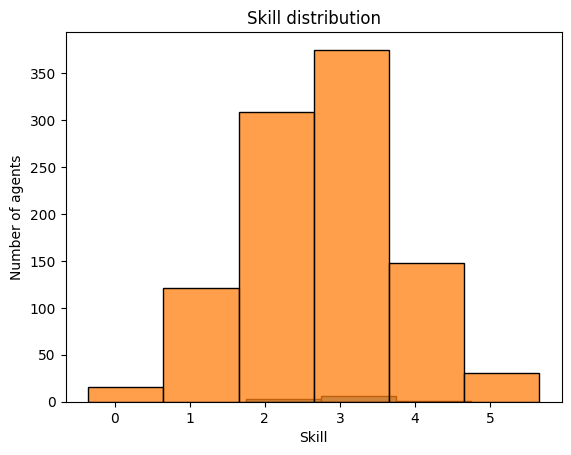

In [369]:
#model = RugbyModel(10)
#for i in range(10):
#    model.step()


plt.show()
%matplotlib inline
skill = [a.skill for a in model.schedule.agents]
# Create a histogram with seaborn
g = sns.histplot(skill, discrete=True)
g.set(
    title="Skill Distribution", xlabel="Type", ylabel="Number of agents"
);

all_skill =[]
for j in range(100):
    # Run the model
    model = RugbyModel(10)
    for i in range(10):
        model.step()
    # Store the results
    for agent in model.schedule.agents:
        all_skill.append(agent.skill)

#Seaborn
g=sns.histplot(all_skill, discrete=True)
g.set(title="Skill distribution", xlabel="Skill", ylabel="Number of agents");

### Trying to make a working interactive viz 

Here we go! 

In [152]:
### Testing Code

import copy
import random
import numpy as np
import mesa

class PlayerAgent(mesa.Agent):
    """A player with fixed initial type and skill."""

    def __init__(self, unique_id, model, agent_type, skill, group):
        super().__init__(unique_id, model)
        self.skill = skill
        self.agent_type = agent_type
        self.group = group

    def fight(self):
        self_combined_score = self.skill * self.agent_type  # Calculate the agent's combined score
        group_ranked = self.model.group_ranked[self.group]  # Get the ranked list from the model

        # Select eligible opponents within the combined score range
        competition = [agent for agent in group_ranked if abs((agent.skill * agent.agent_type) - self_combined_score) <= 0.1]
        if not competition or len(competition) == 1:  # If no or only one agent in competition, no fight occurs
            return

        index = group_ranked.index(self)  # Find self in the ranked list
        adjacent = [agent for i, agent in enumerate(group_ranked) if abs(i - index) == 1 and agent in competition]

        if not adjacent:  # If no adjacent agents in competition, no fight occurs
            return

        opponent = random.choice(adjacent)  # Randomly choose an adjacent agent in competition

        # Randomly decide the outcome of the fight
        fight_outcome = random.random() < 0.5
        winner, loser = (self, opponent) if fight_outcome else (opponent, self)

        # Update type scores for winner and loser
        winner.agent_type = min(winner.agent_type + 0.05, 1)
        loser.agent_type = max(loser.agent_type - 0.08, 0)

        # Update grid positions
        winner_y = min(winner.pos[1] + 1, self.model.grid.height - 1)  # Ensure new position is within grid bounds
        loser_y = max(loser.pos[1] - 1, 0)  # Ensure new position is within grid bounds

        # Move winner and loser to new positions
        self.model.grid.move_agent(winner, (winner.pos[0], winner_y))
        self.model.grid.move_agent(loser, (loser.pos[0], loser_y))

        # Print the outcome
        # print(f"Player {winner.unique_id} won the fight against player {loser.unique_id}.")
    
    def develop(self):
        # Increase the skill score by 0.05, ensure it does not exceed 5
        self.skill = min(self.skill + 0.05, 5)
    
    def step(self):
        # Randomly choose to fight or develop
        action = random.choice(['F', 'D'])
        if action == 'F':
            self.fight()
        else:
            self.develop()
        
        # Print the agent's action for demonstration purposes
        print(f"I am player {self.unique_id}. I chose to {'fight' if action == 'F' else 'develop'}. My type is {self.agent_type}, and my skill is {self.skill}.")

    def self_combined_score(self):
        return self.skill * self.agent_type



class RugbyModel(mesa.Model):
    """A model with some number of players."""

    def __init__(self, N, width=2, height=10):
        height = height if height is not None else (N // 2)
        self.num_agents = N
        self.grid = mesa.space.MultiGrid(width, height, True)
        # Create scheduler and assign it to the model
        self.schedule = mesa.time.RandomActivation(self)

        mu_type, sigma_type = 0.5, 0.15  # mean and standard deviation for type
        mu_skill, sigma_skill = 2.5, 1.0  # mean and standard deviation for skill


        # Create agents
        for i in range(self.num_agents):
            group = '1' if i % 2 == 0 else '2'
            column = 0 if group == '1' else 1  # Assign to column based on group
            x = column
            y = i // 2  # Position in the column

            agent_type = np.clip(np.random.normal(mu_type, sigma_type), 0, 1)
            skill = np.clip(np.random.normal(mu_skill, sigma_skill), 0, 5)

            a = PlayerAgent(i, self, agent_type, skill, group)
            # Add the agent to the scheduler
            self.schedule.add(a)
            self.grid.place_agent(a, (x, y))

    def rank_agents(self):
        # This function will be called to rank agents before they take their steps.
        self.group_ranked = {}
        for group_id in set(agent.group for agent in self.schedule.agents):
            # Create a ranked list for each group
            self.group_ranked[group_id] = sorted(
                [agent for agent in self.schedule.agents if agent.group == group_id],
                key=lambda x: x.skill * x.agent_type
            )

    def step(self):
        """Advance the model by one step."""
        # Rank agents at the start of each step
        self.rank_agents()
        
        # The model's step will go here for now this will call the step method of each agent and print the agent's unique_id
        self.schedule.step()



In [153]:
starter_model = RugbyModel(10)
starter_model.step()

I am player 0. I chose to fight. My type is 0.36562223498207524, and my skill is 1.6544537389190175.
I am player 8. I chose to develop. My type is 0.643230522102169, and my skill is 3.6081454577858714.
I am player 6. I chose to develop. My type is 0.17424973760150414, and my skill is 1.2291013976569767.
I am player 1. I chose to fight. My type is 0.5815662511963469, and my skill is 4.018625842610489.
I am player 2. I chose to develop. My type is 0.6147354001822625, and my skill is 2.570162812019916.
I am player 4. I chose to develop. My type is 0.8095563519950872, and my skill is 2.3593711357682876.
I am player 3. I chose to fight. My type is 0.5927859003098321, and my skill is 2.551337488764901.
I am player 5. I chose to fight. My type is 0.3582193602763841, and my skill is 3.5707658155689126.
I am player 7. I chose to fight. My type is 0.40093144996323304, and my skill is 1.0389774461117023.
I am player 9. I chose to fight. My type is 0.36050783740909453, and my skill is 2.5008433864

In [161]:
def agent_portrayal(agent):
    portrayal = {"shape": "circle", "filled": "true", "r": 0.5}
    if agent.group == '1':
        portrayal["color"] = "red"
    else:
        portrayal["color"] = "blue"
    return portrayal


model_params = {
    "N": {
        "type": "SliderInt",
        "value": 50,
        "label": "Number of agents:",
        "min": 10,
        "max": 100,
        "step": 1,
    },
    "width": 10,
    "height": 10,
}

grid = CanvasGrid(agent_portrayal, model_params["width"], model_params["height"], 500, 500)

server = ModularServer(RugbyModel,
                       [grid],
                       "Rugby Model",
                       model_params)

TypeError: 'dict' object cannot be interpreted as an integer

In [155]:
#from mesa.experimental import JupyterViz

#page = JupyterViz(
 #   RugbyModel,
  #  model_params,
   # measures=["Gini"],
    #name="Money Model",
    #agent_portrayal=agent_portrayal,
#)
# This is required to render the visualization in the Jupyter notebook
#page

from mesa.visualization.modules import CanvasGrid
from mesa.visualization.ModularVisualization import ModularServer

# Assuming a grid size for demonstration; adjust as needed for your model
grid = CanvasGrid(agent_portrayal, 10, 10, 500, 500)

server = ModularServer(RugbyModel,
                       [grid],
                       "Rugby Model",
                       model_params)

TypeError: 'dict' object cannot be interpreted as an integer

END OF MY NOTES 

### Interactive Viz Attempt 2

Here we go... Round 2. 



We want a SingleGrid setup. 
Context is retained with `mesa.space.[class]`. Different classes can be seen as `mesa.space`.
We can place agents through the `place_agent` method, which takes an agent an `x,y` of coordinates. 

In [485]:
### New test code on building visualizations. I think this works!!!     

import copy
import random
import numpy as np
import mesa

##def compute_team_score(model):
##    team_score = [agent.skill * agent.agent_type for agent in model.schedule.agents]
 ##   x = np.array(team_score)
 ##   N = model.num_agents
 #   B = sum(xi * (N - i) for i, xi in enumerate(x)) / (N * sum(x))
 #   return B/N * 100

def compute_team_score(model):
    # Calculate the average of the product of skill and agent type
    team_score_sum = sum(agent.skill * agent.agent_type for agent in model.schedule.agents)
    N = model.num_agents
    average_team_score = team_score_sum / N if N else 0

    # Calculate the percentage of agents who have fought
    agents_fought = sum(agent.won_last_fight for agent in model.schedule.agents)
    percent_fought = (agents_fought / N) if N else 0

    # Subtract the percentage from the average team score
    adjusted_team_score = average_team_score - percent_fought

    return adjusted_team_score

class PlayerAgent(mesa.Agent):
    """A player with fixed initial type and skill."""

    def __init__(self, unique_id, model, agent_type, skill, group):
        super().__init__(unique_id, model)
        self.skill = skill
        self.agent_type = agent_type
        self.group = group
        self.won_last_fight = False  # Track whether the agent won the last fight
    
    def fight(self):
        self_combined_score = self.skill * self.agent_type  # Calculate the agent's combined score
        group_ranked = self.model.group_ranked[self.group]  # Get the ranked list from the model
        
        
        # Select eligible opponents within the combined score range
        competition = [agent for agent in group_ranked if abs((agent.skill * agent.agent_type) - self_combined_score) <= 0.1]
        if not competition:
            print("I had no competition")  # If no or only one agent in competition, no fight occurs
            return
        
        index = group_ranked.index(self)  # Find self in the ranked list
        adjacent = [agent for i, agent in enumerate(group_ranked) if abs(i - index) == 1 and agent in competition]


        if not adjacent:
            #print("I had no adjacent competition")  # If no adjacent agents in competition, no fight occurs
            return

        opponent = random.choice(competition)  # Randomly choose an adjacent agent in competition

        # Randomly decide the outcome of the fight
        winner, loser = (self, opponent) if random.random() < 0.5 else (opponent, self)

        # Find the indices of the winner and loser in the ranked list
        winner_index = self.model.group_ranked[self.group].index(winner)
        loser_index = self.model.group_ranked[self.group].index(loser)

        # Check if the loser is ranked higher than the winner
        if loser_index < winner_index:
            # Swap positions of winner and loser in the grid
            winner_pos = winner.pos
            loser_pos = loser.pos
            self.model.grid.move_agent(winner, loser_pos)
            self.model.grid.move_agent(loser, winner_pos)

            # Also swap their positions in the group_ranked list to reflect the new rankings
            self.model.group_ranked[self.group][winner_index], self.model.group_ranked[self.group][loser_index] = \
            self.model.group_ranked[self.group][loser_index], self.model.group_ranked[self.group][winner_index]
            # Winner increases type score by 0.05, capped at 1
            winner.agent_type = min(winner.agent_type + 0.05, 1)

            # Loser decreases type score by 0.08, not falling below 0
            loser.agent_type = max(loser.agent_type - 0.08, 0)
            #print("I beat someone better than me")

        # Check if self is the winner
        if winner == self:
            self.won_last_fight = True

        # For demonstration purposes, print the outcome
        #print(f"Player {winner.unique_id} won the fight against player {loser.unique_id}.")
    
    def develop(self):
        # Increase the skill score by 0.05, ensure it does not exceed 5
        self.skill = min(self.skill + 0.02, 5)
    
    def move(self):
        # Move the agent only if they won the last fight
        if self.won_last_fight:
            current_x, current_y = self.pos
            possible_steps = [(current_x, current_y - 1), (current_x, current_y + 1)]  # Up/Down movement only
            # Filter out out-of-bounds positions
            self.won_last_fight = False  # Reset the flag after moving

    def self_combined_score(self):
        return self.skill * self.agent_type

    def step(self):
        self.move()
        # Randomly choose to fight or develop
        action = random.choice(['F', 'D'])
        if action == 'F':
            self.fight()
            #print("I fought")
        else:
            self.develop()
            #print("I developed")
        
        # Print the agent's action for demonstration purposes
        #print(f"I am player {self.unique_id}. I chose to {'fight' if action == 'F' else 'develop'}. My type is {self.agent_type}, and my skill is {self.skill}.")

class RugbyModel(mesa.Model):
    """A model with some number of players."""

    def __init__(self, N):
        self.num_agents = N
        self.grid = mesa.space.MultiGrid(2, 5, False)
        self.schedule = mesa.time.RandomActivation(self)
        self.group_ranked = {'1': [], '2': []}

        # Mean and standard deviation for type and skill
        mu_type, sigma_type = 0.5, 0.15
        mu_skill, sigma_skill = 2.5, 1.0

        # Create agents
        for i in range(self.num_agents):
            group = '1' if i % 2 == 0 else '2'
            agent_type = np.clip(np.random.normal(mu_type, sigma_type), 0, 1)
            skill = np.clip(np.random.normal(mu_skill, sigma_skill), 0, 5)
            a = PlayerAgent(i, self, agent_type, skill, group)
            self.group_ranked[group].append(a)  # Add the agent to the group_ranked

        # Rank agents in each group
        self.rank_agents()

        # Place agents on the grid based on their group and rank
        for group, agents in self.group_ranked.items():
            x = 0 if group == '1' else 1
            for y, agent in enumerate(agents):
                self.grid.place_agent(agent, (x, y))
                self.schedule.add(agent)  # Add the agent to the scheduler

        self.datacollector = mesa.DataCollector(
            model_reporters={"Team Score": compute_team_score},
            agent_reporters={"Type": "agent_type", "Skill": "skill"}
        )
        

    def rank_agents(self):
        # Rank the agents in each group by their combined score
        for group_id, agents in self.group_ranked.items():
            sorted_agents = sorted(agents, key=lambda a: (a.skill * a.agent_type, -a.unique_id))
            self.group_ranked[group_id] = sorted_agents  # Update the dictionary with sorted lists


    def step(self):
        """Advance the model by one step."""
        # Rank agents at the start of each step
        for group_id in self.group_ranked:
            self.group_ranked[group_id].sort(key=lambda x: x.skill * x.agent_type)
        
        self.datacollector.collect(self)

        # The model's step will go here for now this will call the step method of each agent and print the agent's unique_id
        self.schedule.step()


In [391]:
model = RugbyModel(10)
for i in range(20):
    model.step()

In [399]:


model = RugbyModel(10)
for i in range(30):
    model.step()

In [440]:
skill = model.datacollector.get_model_vars_dataframe()
print(skill.head())

   Team Score
0    1.323834
1    1.319034
2    1.324436
3    1.327708
4    1.334531


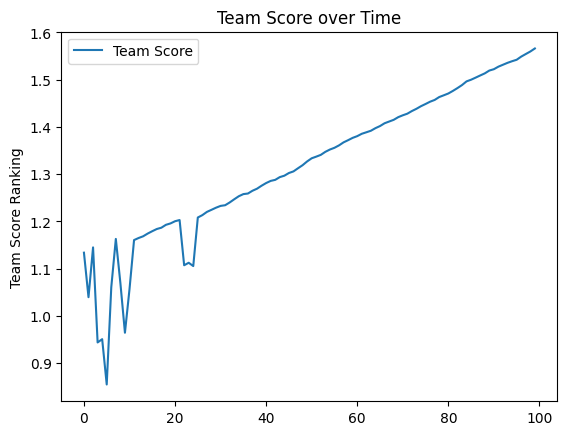

In [514]:
model = RugbyModel(10)
for i in range(100):
    model.step()

skill = model.datacollector.get_model_vars_dataframe()
g = sns.lineplot(data=skill)
###g.set(title="Team Score over Time", ylabel="Team Score Ranking");

             Type     Skill
AgentID                    
2        0.573318  2.786395
8        0.293442  3.409831
6        0.395527  4.425908
0        0.493527  4.494436
4        0.613803  4.075612
5        0.318120  2.143598
1        0.335641  2.878851
7        0.413330  3.205531
9        0.399830  3.518468
3        0.802585  2.757614


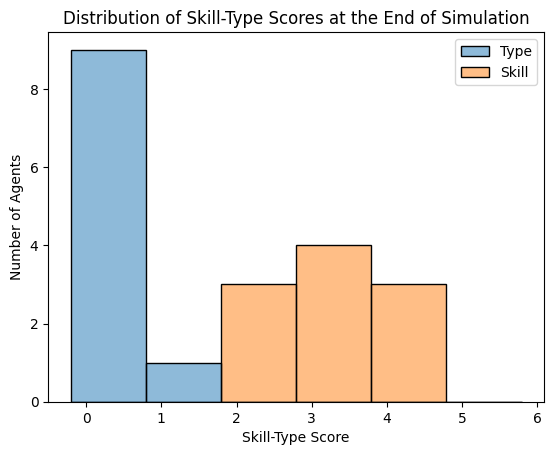

In [527]:
# Assuming 'team_score' is the DataFrame containing the team score at each step
# and 'agent_scores' is the DataFrame containing each agent's skill-type score at each step.

# Extract the team score and agent scores from the datacollector
team_score = model.datacollector.get_model_vars_dataframe()["Team Score"]
agent_scores = model.datacollector.get_agent_vars_dataframe()

last_step = team_score.index[-1]

# Get the skill-type scores of all agents at the last step
end_scores = agent_scores.xs(last_step, level="Step")

print(end_scores)

# Create a histogram of the skill-type scores at the last step
g = sns.histplot(end_scores, discrete=True)
g.set(
    title="Distribution of Skill-Type Scores at the End of Simulation",
    xlabel="Skill-Type Score",
    ylabel="Number of Agents",
)

# Show the plot
plt.show()

                  Type     Skill
Step AgentID                    
0    2        0.603318  1.826395
     8        0.483442  2.429831
     6        0.375527  3.545908
     0        0.443527  3.594436
     4        0.613803  3.235612
...                ...       ...
99   5        0.318120  2.143598
     1        0.335641  2.878851
     7        0.413330  3.205531
     9        0.399830  3.518468
     3        0.802585  2.757614

[1000 rows x 2 columns]


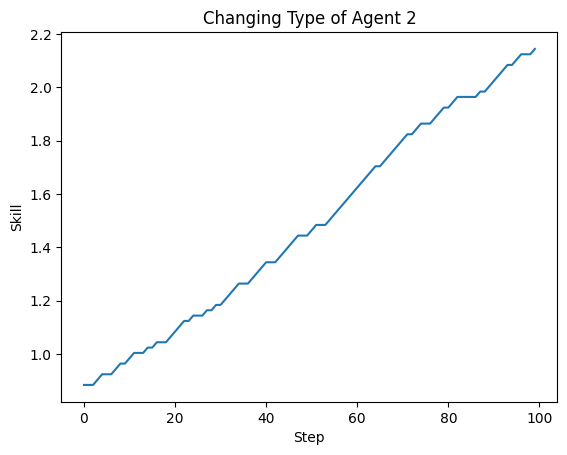

In [556]:
print(agent_scores)

one_agent_scores = agent_scores.xs(5, level="AgentID")

g = sns.lineplot(data=one_agent_scores, x = "Step", y = "Skill")
g.set(title="Changing Type of Agent 2");

### Average Skills 



[Text(0.5, 1.0, 'Average scores over time')]

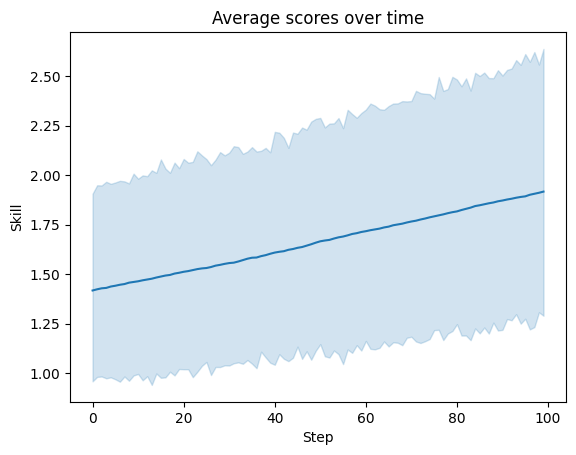

In [560]:
# Transform the data to a long format
agent_scores_long = agent_scores.T.unstack().reset_index()
agent_scores_long.columns = ["Step", "AgentID", "Type", "Skill"]
agent_scores_long.head(3)

# Plot the average wealth over time
g = sns.lineplot(data=agent_scores_long, x="Step", y="Skill", errorbar=("ci", 95))
g.set(title="Average scores over time")

Tests!

In [561]:
# save the model data (stored in the pandas gini object) to CSV
skill.to_csv("model_data.csv")

# save the agent data (stored in the pandas agent_wealth object) to CSV
agent_scores.to_csv("agent_data.csv")

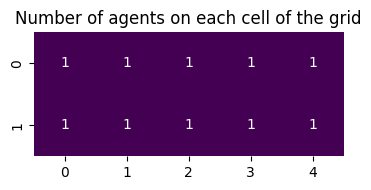

In [515]:
### Working (but weird) visualization

agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell_content, (x, y) in model.grid.coord_iter():
    agent_count = 0 if cell_content is None else 1  # Check if the cell is empty or contains an agent
    agent_counts[x][y] = agent_count

# Now, you can plot the heatmap with the corrected agent_counts
import seaborn as sns
import matplotlib.pyplot as plt

# Plot using seaborn, with a size of 5x5
g = sns.heatmap(agent_counts, cmap="viridis", annot=True, cbar=False, square=True)
g.figure.set_size_inches(4, 4)
g.set(title="Number of agents on each cell of the grid")
plt.show()  # Display the plot

In [465]:
### Better Visualization Based on Scores

### Different Visualization Attempt


import matplotlib.pyplot as plt
import numpy as np

# Assuming `agent_scores` is a 2x5 NumPy array with the combined scores
agent_scores = np.zeros((5, 2))  # 5 rows and 2 columns
for cell_content, (x, y) in model.grid.coord_iter():
    if cell_content is not None:  # Check if the cell is not empty
        agent_scores[x][y] = cell_content.self_combined_score()  # Use the agent's combined score
    else:
        agent_scores[x][y] = 0  # If the cell is empty, set the score to 0

# Now, create a figure and a scatter plot
fig, ax = plt.subplots()
ax.set_xlim(-0.5, 1.5)  # Set x limits to show 2 columns
ax.set_ylim(-0.5, 4.5)  # Set y limits to show 5 rows

# Set the aspect of the plot to equal to have circles appear as circles
ax.set_aspect('equal')

# Create an array with the center coordinates of each grid cell
x_coords, y_coords = np.meshgrid(range(agent_scores.shape[1]), range(agent_scores.shape[0]))

# Flatten the arrays to use in scatter plot
x_coords = x_coords.flatten()
y_coords = y_coords.flatten()
scores = agent_scores.flatten()

# Create a scatter plot, where the size and color of the circles correspond to the agent scores
scatter = ax.scatter(x_coords, y_coords, s=scores * 1000, c=scores, cmap="viridis", alpha=0.6, edgecolors="w")

# Add annotations inside the circles
for i, score in enumerate(scores):
    ax.annotate(f"{score:.2f}", (x_coords[i], y_coords[i]), va='center', ha='center', color='black')

# Remove the color bar by not creating it

# Hide the grid lines and ticks
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])

# Add a title
plt.title("Combined score of agents on each cell of the grid")

# Show the plot
plt.show()


# Now, you can plot the heatmap with the agent_scores
import seaborn as sns
import matplotlib.pyplot as plt

# Plot using seaborn, with the combined scores
g = sns.heatmap(agent_scores, cmap="viridis", annot=True, cbar=True, square=True)
g.figure.set_size_inches(4, 4)
g.set(title="Combined score of agents on each cell of the grid")
plt.show()  # Display the plot

AttributeError: 'list' object has no attribute 'self_combined_score'

Each agent's position is stored as a grid position and a coordination tuple. The `place_agent` method adds the coordinate to the agent automatically. 

#### Behavior

__Movement__: agents can move to a neighboring cell. The grid object provides a `move_agent` method. This leaves us with possible neighboring cells to move to. 

Use the grid's built-in `get_neighborhood` method, which returns all the neighbors of a given cell. This method can get two types of cell neighborhoods: __Moore__ (includes all 8 surrounding squares), and __Von Neumann__ (only up/down/left/right). It also needs an argument as to whether to include the center cell itself as one of the neighbors.
With that in mind, the agent's move method looks like this:

In [28]:
class MoneyAgent(mesa.Agent):
   #...
    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

Next, we need to get all the other agents present in a cell, and give one of them some money. We can get the contents of one or more cells using the grid's get_cell_list_contents method, or by accessing a cell directly. The method accepts a list of cell coordinate tuples, or a single tuple if we only care about one cell.

This then means that the `step` method becomes: 

In [30]:
class MoneyAgent(mesa.Agent):
    # ...
    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()

In [31]:
class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=False
        )
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other_agent = self.random.choice(cellmates)
            other_agent.wealth += 1
            self.wealth -= 1

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()


class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = mesa.space.MultiGrid(width, height, True)
        self.schedule = mesa.time.RandomActivation(self)
        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

    def step(self):
        self.schedule.step()

In [373]:
model = RugbyModel(10)
for i in range(20):
    model.step()

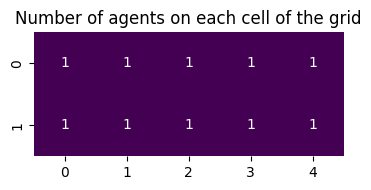

In [309]:
agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell_content, (x, y) in model.grid.coord_iter():
    agent_count = 0 if cell_content is None else 1  # Check if the cell is empty or contains an agent
    agent_counts[x][y] = agent_count

# Now, you can plot the heatmap with the corrected agent_counts
import seaborn as sns
import matplotlib.pyplot as plt

# Plot using seaborn, with a size of 5x5
g = sns.heatmap(agent_counts, cmap="viridis", annot=True, cbar=False, square=True)
g.figure.set_size_inches(4, 4)
g.set(title="Number of agents on each cell of the grid")
plt.show()  # Display the plot

In [305]:
### Different Visualization Attempt

agent_scores = np.zeros((model.grid.width, model.grid.height))
for cell_content, (x, y) in model.grid.coord_iter():
    if cell_content is not None:  # Check if the cell is not empty
        agent_scores[x][y] = cell_content.self_combined_score()  # Use the agent's combined score
    else:
        agent_scores[x][y] = 0  # If the cell is empty, set the score to 0

# Now, you can plot the heatmap with the agent_scores
import seaborn as sns
import matplotlib.pyplot as plt

# Plot using seaborn, with the combined scores
g = sns.heatmap(agent_scores, cmap="viridis", annot=True, cbar=True, square=True)
g.figure.set_size_inches(4, 4)
g.set(title="Combined score of agents on each cell of the grid")
plt.show()  # Display the plot

AttributeError: 'list' object has no attribute 'self_combined_score'

In [304]:
agent_scores = {group: [] for group in ['1', '2']}
for agent in model.schedule.agents:
    agent_scores[agent.group].append(agent.self_combined_score())

group_ranked = model.group_ranked[group]
rank = [agent for agent in group_ranked]

unique_ids = 

# Convert the scores into a numpy array for plotting
scores_array = np.zeros((5, 2))  # 5 rows and 2 columns, initialized to zero
for group, scores in agent_scores.items():
    x = 0 if group == '1' else 1
    scores = sorted(scores, reverse=False)  # Sort scores so the highest is at the top
    for y, score in enumerate(scores):
        scores_array[y, x] = score

# Now create the scatter plot
fig, ax = plt.subplots()
ax.set_xlim(-0.5, 1.5)  # Set x limits to show 2 columns (groups)
ax.set_ylim(-0.5, 4.5)  # Set y limits to show 5 rows (ranking)
ax.set_aspect('equal')

for y in range(agent_scores.shape[0]):
    for x in range(agent_scores.shape[1]):
        score = agent_scores[y, x]
        uid = unique_ids[y, x]
        ax.scatter(x, y, s=100, color='blue', edgecolors='black')  # Fixed size for all circles
        ax.annotate(f"{score:.2f}", (x, y), va='center', ha='center', color='black')
        ax.annotate(str(uid), (x, y), va='center', ha='center', color='red', fontsize=8)

# Plot each score as a circle in the scatter plot
for y in range(scores_array.shape[0]):
    for x in range(scores_array.shape[1]):
        score = scores_array[y, x]
        ax.scatter(x, y, s=600, color='white', edgecolors='black')  # Fixed size for all circles
        if score > 0:  # Only annotate non-zero scores
            ax.annotate(f"{score:.2f}", (x, y), va='center', ha='center', color='black')

ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
plt.title("Agent Scores by Group and Rank")
plt.show()

SyntaxError: invalid syntax (1618349135.py, line 5)

AttributeError: 'dict' object has no attribute 'shape'

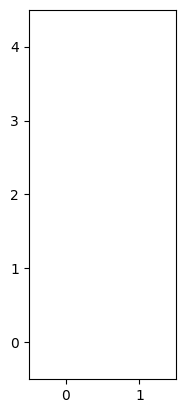

In [267]:



# ... Assume agent_scores is already populated with the combined scores ...

# Create a figure and a scatter plot
fig, ax = plt.subplots()

# Set the axes' limits
ax.set_xlim(-0.5, 1.5)  # Set x limits to show 2 columns (groups)
ax.set_ylim(-0.5, 4.5)  # Set y limits to show 5 rows (ranking)

# Set the aspect of the plot to equal to have circles appear as circles
ax.set_aspect('equal')

# Plot each score as a circle in the scatter plot
for y in range(agent_scores.shape[0]):
    for x in range(agent_scores.shape[1]):
        score = agent_scores[y, x]
        uid = unique_ids_array[y, x]
        ax.scatter(x, y, s=100, color='blue', edgecolors='black')  # Fixed size for all circles
        # Annotate with score and unique_id
        ax.annotate(f"{score:.2f}\n{uid}", (x, y), va='center', ha='center', color='black', fontsize=8)

# Hide the grid lines and ticks
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])

# Add a title
plt.title("Agent Scores by Group and Rank")

# Show the plot
plt.show()


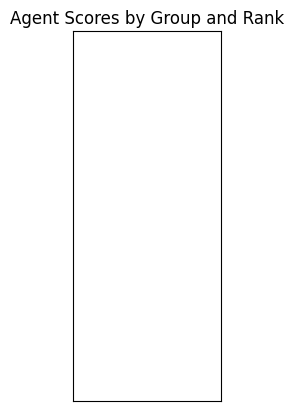

In [303]:
# Assuming agent_scores is a dictionary with lists of scores for each group
agent_scores = {'1': [], '2': []}

# Convert the dictionary to a NumPy array
scores_array = np.array(list(agent_scores.values())).T  # Transpose to get the correct shape (5, 2)

# Assuming unique_ids is a dictionary with lists of unique IDs for each group
unique_ids = {'1': [], '2': []}

# Convert the dictionary to a NumPy array
ids_array = np.array(list(unique_ids.values())).T  # Transpose to get the correct shape (5, 2)


# Create a figure and a scatter plot
fig, ax = plt.subplots()

# Set the axes' limits
ax.set_xlim(-0.5, 1.5)  # Set x limits to show 2 columns (groups)
ax.set_ylim(-0.5, 4.5)  # Set y limits to show 5 rows (ranking)

# Set the aspect of the plot to equal to have circles appear as circles
ax.set_aspect('equal')

# Plot each score as a circle in the scatter plot
for y in range(scores_array.shape[0]):
    for x in range(scores_array.shape[1]):
        score = scores_array[y, x]
        uid = ids_array[y, x]
        ax.scatter(x, y, s=100, color='blue', edgecolors='black')  # Fixed size for all circles
        # Annotate with score and unique_id
        ax.annotate(f"{score:.2f}\n{uid}", (x, y), va='center', ha='center', color='black', fontsize=8)

# Hide the grid lines and ticks
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])

# Add a title
plt.title("Agent Scores by Group and Rank")

# Show the plot
plt.show()



#### Collecting Data

At the end of each model run, we've had to write our own code to get the data. Mesa provides a class to handle data collection and storage for us. 

Collector stores: model-level variables, agent-level variables, and tables. Model- and agent-level variables are added to the data collector along with a function for collecting them. Model-level collection functions take a model object as an input, while agent-level collection functions take an agent object as an input. Both then return a value computed from the model or each agent at their current state. When the data collector’s collect method is called, with a model object as its argument, it applies each model-level collection function to the model, and stores the results in a dictionary, associating the current value with the current step of the model. Similarly, the method applies each agent-level collection function to each agent currently in the schedule, associating the resulting value with the step of the model, and the agent’s unique_id.
Let's add a DataCollector to the model with mesa.DataCollector, and collect two variables. At the agent level, we want to collect every agent's wealth at every step. At the model level, let's measure the model's Gini Coefficient, a measure of wealth inequality.

In [34]:
def compute_type(model):
    agent_types = [agent.type for agent in model.schedule.agents]
    x = sorted(agent_types)
    N = model.num_agents
    B = sum(xi * (N - i) for i, xi in enumerate(x)) / (N * sum(x))
    return 1 + (1 / N) - 2 * B


class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=False
        )
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        cellmates.pop(
            cellmates.index(self)
        )  # Ensure agent is not giving money to itself
        if len(cellmates) > 1:
            other = self.random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1
            if other == self:
                print("I JUST GAVE MONEY TO MYSELF HEHEHE!")

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()


class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = mesa.space.MultiGrid(width, height, True)
        self.schedule = mesa.time.RandomActivation(self)

        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        self.datacollector = mesa.DataCollector(
            model_reporters={"Gini": compute_gini}, agent_reporters={"Wealth": "wealth"}
        )

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

At every step, the datacollector will collect and store model-level Gini coefficiants, agent's wealth, and connect it to each step. 


In [37]:
model = MoneyModel(100, 10, 10)
for i in range(1000):
    model.step()

To get the series of Gini coefficients as a pandas DataFrame:

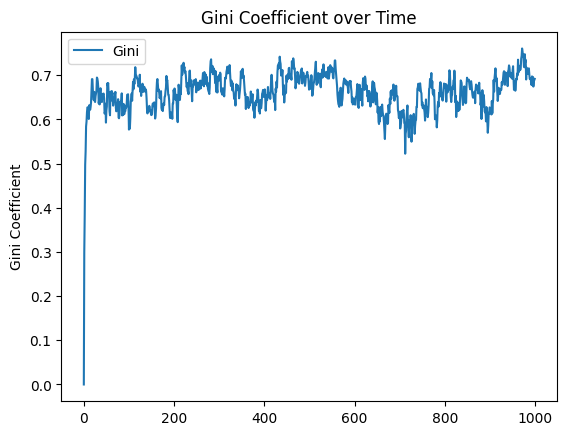

In [38]:
gini = model.datacollector.get_model_vars_dataframe()
# Plot the Gini coefficient over time
g = sns.lineplot(data=gini)
g.set(title="Gini Coefficient over Time", ylabel="Gini Coefficient");

Agent-wealth data

In [39]:
agent_wealth = model.datacollector.get_agent_vars_dataframe()
agent_wealth.head()

Wealth
Step AgentID        
0    0             1
     1             1
     2             1
     3             1
     4             1

You get model step and agent ID, alongside wealth. Data collector stores data in a dictionary, with te step number as the key and the agent ID and variable value pairs as the value. datacollector then converts this to a dataframe. This can be analyzed like any other df. 

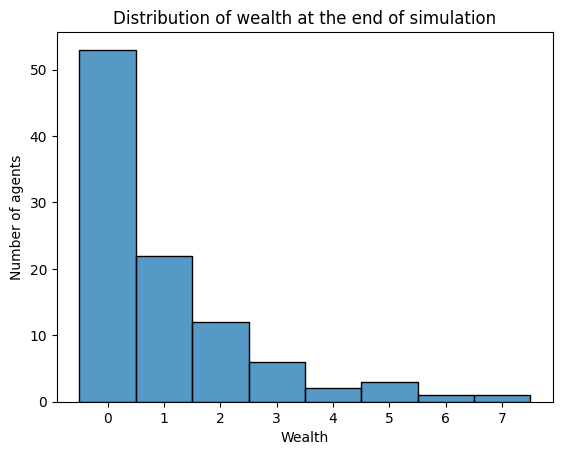

In [40]:
last_step = agent_wealth.index.get_level_values("Step").max()
end_wealth = agent_wealth.xs(last_step, level="Step")["Wealth"]
# Create a histogram of wealth at the last step
g = sns.histplot(end_wealth, discrete=True)
g.set(
    title="Distribution of wealth at the end of simulation",
    xlabel="Wealth",
    ylabel="Number of agents",
);

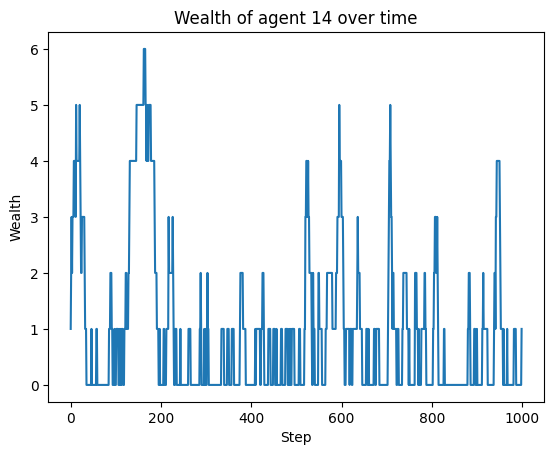

In [41]:
# Get the wealth of agent 14 over time
one_agent_wealth = agent_wealth.xs(14, level="AgentID")

# Plot the wealth of agent 14 over time
g = sns.lineplot(data=one_agent_wealth, x="Step", y="Wealth")
g.set(title="Wealth of agent 14 over time");

Reporting multiple agent wealth

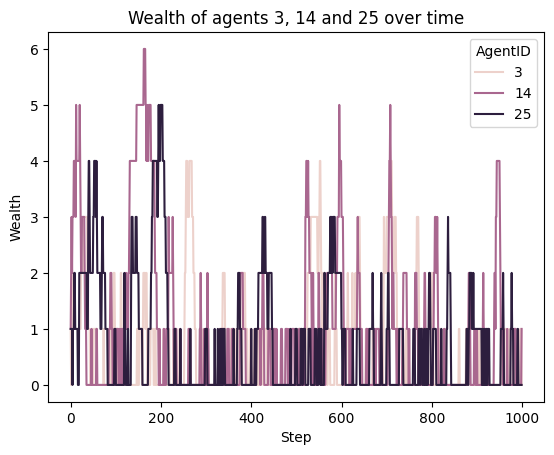

In [42]:
agent_list = [3, 14, 25]

# Get the wealth of multiple agents over time
multiple_agents_wealth = agent_wealth[
    agent_wealth.index.get_level_values("AgentID").isin(agent_list)
]
# Plot the wealth of multiple agents over time
g = sns.lineplot(data=multiple_agents_wealth, x="Step", y="Wealth", hue="AgentID")
g.set(title="Wealth of agents 3, 14 and 25 over time");

Average of all agents, with a 95%$ CI

[Text(0.5, 1.0, 'Average wealth over time')]

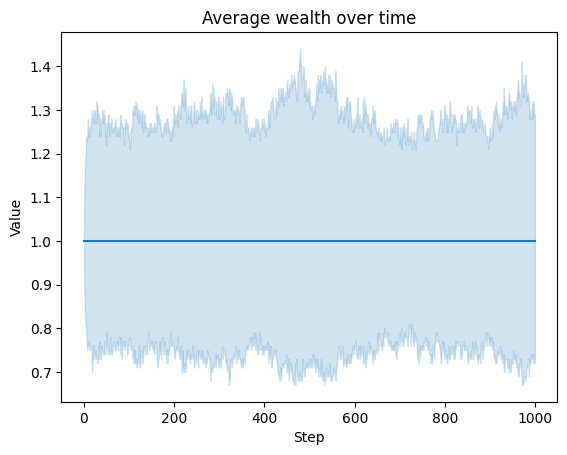

In [43]:
# Transform the data to a long format
agent_wealth_long = agent_wealth.T.unstack().reset_index()
agent_wealth_long.columns = ["Step", "AgentID", "Variable", "Value"]
agent_wealth_long.head(3)

# Plot the average wealth over time
g = sns.lineplot(data=agent_wealth_long, x="Step", y="Value", errorbar=("ci", 95))
g.set(title="Average wealth over time")

In [44]:
# save the model data (stored in the pandas gini object) to CSV
gini.to_csv("model_data.csv")

# save the agent data (stored in the pandas agent_wealth object) to CSV
agent_wealth.to_csv("agent_data.csv")

#### Batch Run 

Like we mentioned above, you usually won't run a model only once, but multiple times, with fixed parameters to find the overall distributions the model generates, and with varying parameters to analyze how they drive the model's outputs and behaviors. Instead of needing to write nested for-loops for each model, Mesa provides a `batch_run` function which automates it for you.

The batch runner also requires an additional variable self.running for the MoneyModel class. This variable enables conditional shut off of the model once a condition is met. In this example it will be set as True indefinitely.

In [45]:
def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum(xi * (N - i) for i, xi in enumerate(x)) / (N * sum(x))
    return 1 + (1 / N) - 2 * B


class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = mesa.space.MultiGrid(width, height, True)
        self.schedule = mesa.time.RandomActivation(self)
        self.running = True

        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        self.datacollector = mesa.DataCollector(
            model_reporters={"Gini": compute_gini}, agent_reporters={"Wealth": "wealth"}
        )

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

#### Things to bear in mind

We call batch_run with the following arguments:
`model_cls` 

The model class that is used for the batch run. 

`parameters`

A dictionary containing all the parameters of the model class and desired values to use for the batch run as key-value pairs. Each value can either be fixed ( e.g. {"height": 10, "width": 10}) or an iterable (e.g. {"N": range(10, 500, 10)}). batch_run will then generate all possible parameter combinations based on this dictionary and run the model iterations times for each combination. 

`number_processes`

If not specified, defaults to 1. Set it to None to use all the available processors. 

Note: Multiprocessing does make debugging challenging. If your parameter sweeps are resulting in unexpected errors set number_processes = 1. 

`iterations`

The number of iterations to run each parameter combination for. Optional. If not specified, defaults to 1.

`data_collection_period`

The length of the period (number of steps) after which the model and agent reporters collect data. Optional. If not specified, defaults to -1, i.e. only at the end of each episode.

`max_steps`

The maximum number of time steps after which the model halts. An episode does either end when self.running of the model class is set to False or when model.schedule.steps == max_steps is reached. Optional. If not specified, defaults to 1000. 

`display_progress` 

Display the batch run progress. Optional. If not specified, defaults to True.

In the following example, we hold the height and width fixed, and vary the number of agents. We tell the batch runner to run 5 instantiations of the model with each number of agents, and to run each for 100 steps.
We want to keep track of
1. the Gini coefficient value and
2. the individual agent's wealth development.

Since for the latter changes at each time step might be interesting, we set data_collection_period = 1.
Note: The total number of runs is 245 (= 49 different populations * 5 iterations per population). However, the resulting list of dictionaries will be of length 6186250 (= 250 average agents per population * 49 different populations * 5 iterations per population * 101 steps per iteration).

In [46]:
params = {"width": 10, "height": 10, "N": range(10, 500, 10)}

results = mesa.batch_run(
    MoneyModel,
    parameters=params,
    iterations=5,
    max_steps=100,
    number_processes=1,
    data_collection_period=1,
    display_progress=True,
)

  0%|          | 0/245 [00:00<?, ?it/s]

Convert batch run to a list of dictionaries to a Pandas df and print its keys 

In [47]:
results_df = pd.DataFrame(results)
print(results_df.keys())

Index(['RunId', 'iteration', 'Step', 'width', 'height', 'N', 'Gini', 'AgentID',
       'Wealth'],
      dtype='object')


First, we want to take a closer look at how the Gini coefficient at the end of each episode changes as we increase the size of the population. For this, we filter our results to only contain the data of one agent (the Gini coefficient will be the same for the entire population at any time) at the 100th step of each episode and then scatter-plot the values for the Gini coefficient over the the number of agents. Notice there are five values for each population size since we set iterations=5 when calling the batch run.

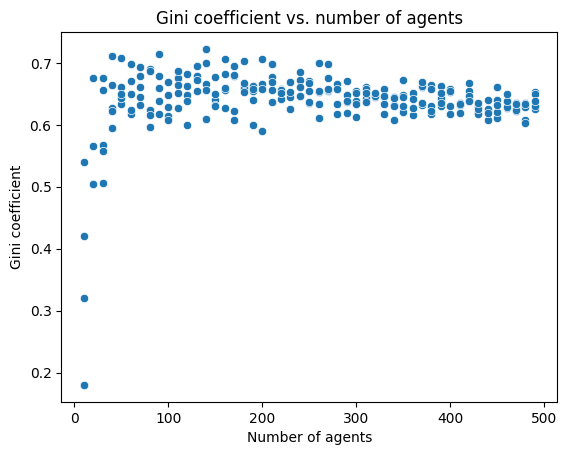

In [48]:
# Filter the results to only contain the data of one agent (the Gini coefficient will be the same for the entire population at any time) at the 100th step of each episode
results_filtered = results_df[(results_df.AgentID == 0) & (results_df.Step == 100)]
results_filtered[["iteration", "N", "Gini"]].reset_index(
    drop=True
).head()  # Create a scatter plot
g = sns.scatterplot(data=results_filtered, x="N", y="Gini")
g.set(
    xlabel="Number of agents",
    ylabel="Gini coefficient",
    title="Gini coefficient vs. number of agents",
);

Second, we want to display the agent's wealth at each time step of one specific episode. To do this, we again filter our large data frame, this time with a fixed number of agents and only for a specific iteration of that population. To print the results, we convert the filtered data frame to a string specifying the desired columns to print.
Pandas has built-in functions to convert to a lot of different data formats. For example, to display as a table in a Jupyter Notebook, we can use the to_html() function which takes the same arguments as to_string() (see commented lines).

In [49]:
# First, we filter the results
one_episode_wealth = results_df[(results_df.N == 10) & (results_df.iteration == 2)]
# Then, print the columns of interest of the filtered data frame
print(
    one_episode_wealth.to_string(
        index=False, columns=["Step", "AgentID", "Wealth"], max_rows=25
    )
)
# For a prettier display we can also convert the data frame to html, uncomment to test in a Jupyter Notebook
# from IPython.display import display, HTML
# display(HTML(one_episode_wealth.to_html(index=False, columns=['Step', 'AgentID', 'Wealth'], max_rows=25)))

 Step  AgentID  Wealth
    0        0       1
    0        1       1
    0        2       1
    0        3       1
    0        4       1
    0        5       1
    0        6       1
    0        7       1
    0        8       1
    0        9       1
    1        0       1
    1        1       1
  ...      ...     ...
   99        8       1
   99        9       1
  100        0       1
  100        1       2
  100        2       1
  100        3       1
  100        4       0
  100        5       1
  100        6       1
  100        7       1
  100        8       1
  100        9       1


In [50]:
results_one_episode = results_df[
    (results_df.N == 10) & (results_df.iteration == 1) & (results_df.AgentID == 0)
]
print(results_one_episode.to_string(index=False, columns=["Step", "Gini"], max_rows=25))

 Step  Gini
    0  0.00
    1  0.00
    2  0.00
    3  0.00
    4  0.00
    5  0.00
    6  0.00
    7  0.00
    8  0.00
    9  0.00
   10  0.00
   11  0.00
  ...   ...
   89  0.18
   90  0.18
   91  0.18
   92  0.18
   93  0.18
   94  0.18
   95  0.18
   96  0.18
   97  0.18
   98  0.18
   99  0.18
  100  0.18
